## Parsing PDF example

This notebook shows the basic steps to parse a PDF image using layoutparser and google ocr/tesseract.

In [7]:
import layoutparser as lp
from pathlib import Path
from layoutparser.ocr.tesseract_agent import TesseractAgent
import numpy as np
import os
from copy import copy
from layoutparser.elements.layout_elements import TextBlock
from typing import Union

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../credentials/credentials.json"

In [ ]:
# create downloads folder at root of repo and run scripts/fep_pypaperbot_example.sh to download these examples
path = Path("../downloads")

In [ ]:
# Let's get a single image as an example.
for file in path.iterdir():
    # file_name = file.name
    pdf_tokens, pdf_images = lp.load_pdf(file, load_images=True)
    break

In [ ]:
type(pdf_images[0])

In [ ]:
# Start with the simplest fastest model. Model zoo has more complex models if we want to use them.
model = lp.AutoLayoutModel("lp://efficientdet/PubLayNet/tf_efficientdet_d0")
model2=lp.AutoLayoutModel("lp://mask_rcnn_X_101_32x8d_FPN_3x/config")

In [13]:
model

In [14]:
model2

In [15]:
image = pdf_images[11]

In [16]:
layout = model.detect(image)  # The page with reference
im=lp.draw_box(image, layout)
im.save("../downloads/example_page.png")

/home/stefan/autodidact/venv/lib/python3.8/site-packages/effdet/bench.py:55: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


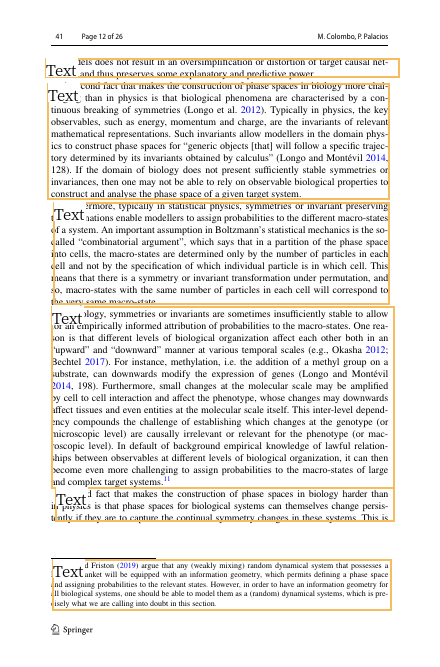

In [17]:
lp.draw_box(image, layout, show_element_type=True)

We can see that layoutparser has parsed things as expected. We may want to pad the examples before OCR as things are a little tight!

In [18]:
text_blocks = lp.Layout([b for b in layout if b.type == "Text"])
image = np.asarray(image)
tesseract_ocr_agent = TesseractAgent(languages="eng")
google_ocr_agent = lp.GCVAgent(languages="eng")

## Google OCR vs Tesseract OCR

In [19]:
def set_block_texts(
    ocr_agent: Union[lp.TesseractAgent, lp.GCVAgent],
    block: TextBlock,
    left_pad: int = 15,
    right_pad: int = 5,
    top_pad: int = 5,
    bottom_pad: int = 5,
) -> None:
    """Set the text of a block inplace using the Google or Tesseract OCR agents.

    :param ocr_agent: Agent to use for OCR. Google or Tesseract.
    :param block: Block to set text of.
    :return: None.
    """
    # Crop image around the detected layout, padding to improve OCR accuracy
    segment_image = block.pad(
        left=left_pad, right=right_pad, top=top_pad, bottom=bottom_pad
    ).crop_image(image)

    # Perform OCR
    text = ocr_agent.detect(segment_image, return_only_text=True)

    # Save OCR result
    block.set(text=text, inplace=True)


google_text_blocks = copy(text_blocks)

# Google OCR gives confidence scores for each character.
for block in google_text_blocks:
    set_block_texts(google_ocr_agent, block)

for txt in google_text_blocks:
    print(txt.text, end="\n---\n")

Furthermore, typically in statistical physics, symmetries or invariant preserving
transformations enable modellers to assign probabilities to the different macro-states
of a system. An important assumption in Boltzmann's statistical mechanics is the so-
called "combinatorial argument", which says that in a partition of the phase space
into cells, the macro-states are determined only by the number of particles in each
cell and not by the specification of which individual particle is in which cell. This
means that there is a symmetry or invariant transformation under permutation, and
so, macro-states with the same number of particles in each cell will correspond to
the very same macro-state.
---
A second fact that makes the construction of phase spaces in biology more chal-
lenging than in physics is that biological phenomena are characterised by a con-
tinuous breaking of symmetries (Longo et al. 2012). Typically in physics, the key
observables, such as energy, momentum and charge, are 

In [40]:
tesseract_text_blocks = copy(google_text_blocks)
for block in tesseract_text_blocks:
    set_block_texts(tesseract_ocr_agent, block)
for txt in tesseract_text_blocks:
    print(txt.text, end="\n---\n")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

We can see that the Google OCR is better than the Tesseract OCR. This isn't surprising as it's a paid service. But it's relatively cheap and we can use it for our purposes.

In [41]:
google_text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=54.379119873046875, y_1=202.6986846923828, x_2=388.1790771484375, y_2=304.2880554199219), text=Furthermore, typically in statistical physics, symmetries or invariant preserving
‘eansformations enable modellers to assign probabilities tothe detent marostats
‘ofa systm. An important assumption in Boltzmany’s staistical mechanics isthe
called “combinatorial argument’. which says that in a parion ofthe phase space
Im calls, the mactosates are determined oly by the numberof particles ia each
call and ot by the specification of which individual parce sin which cel, This
‘means that there i asymmetry o¢ invariant wansformation under permutation, abd
So, macro-sates with the same numberof particles in each cell wil eorespond 0
the very same macro-state.

, id=0, type=Text, parent=None, next=None, score=0.9736777544021606), TextBlock(block=Rectangle(x_1=48.45265197753906, y_1=83.14635467529297, x_2=388.4099884033203, y_2=199.429443359375), text= 

A

In [42]:
google_text_blocks.to_dict()

{'page_data': {},
 'blocks': [{'x_1': 54.379119873046875,
   'y_1': 202.6986846923828,
   'x_2': 388.1790771484375,
   'y_2': 304.2880554199219,
   'block_type': 'rectangle',
   'text': 'Furthermore, typically in statistical physics, symmetries or invariant preserving\n‘eansformations enable modellers to assign probabilities tothe detent marostats\n‘ofa systm. An important assumption in Boltzmany’s staistical mechanics isthe\ncalled “combinatorial argument’. which says that in a parion ofthe phase space\nIm calls, the mactosates are determined oly by the numberof particles ia each\ncall and ot by the specification of which individual parce sin which cel, This\n‘means that there i asymmetry o¢ invariant wansformation under permutation, abd\nSo, macro-sates with the same numberof particles in each cell wil eorespond 0\nthe very same macro-state.\n\x0c',
   'id': 0,
   'type': 'Text',
   'score': 0.9736777544021606},
  {'x_1': 48.45265197753906,
   'y_1': 83.14635467529297,
   'x_2': 388.

In [ ]:
google_text_blocks[0].to_dict()

## Parsing a PDF

There's no need for our own classes to store the data in json. We can subclass layoutparser stuff if we need to add extra stuff.


# Encoding

We really need to scriptify the output from the OCR. But for now, let's just check the encoding is working properly.

In [15]:

from abc import ABC, abstractmethod
from typing import List

from sentence_transformers import SentenceTransformer
import numpy as np


class SentenceEncoder(ABC):
    """Base class for a sentence encoder"""

    @abstractmethod
    def encode(self, text: str) -> np.ndarray:
        """Encode a string, return a numpy array."""
        raise NotImplementedError

    @abstractmethod
    def encode_batch(self, text_batch: List[str], batch_size: int) -> np.ndarray:
        """Encode a batch of strings, return a numpy array."""
        raise NotImplementedError

    @property
    @abstractmethod
    def dimension(self) -> int:
        """Return the dimension of the embeddings produced by the encoder."""
        raise NotImplementedError


class SBERTEncoder(SentenceEncoder):
    """Encoder which uses the sentence-transformers library.

    A list of pretrained models is available at https://www.sbert.net/docs/pretrained_models.html.
    """

    def __init__(self, model_name: str):
        super(SBERTEncoder).__init__()
        # logger.debug("Downloading sentence-transformers model")
        self.encoder = SentenceTransformer(model_name)

    def encode(self, text: str) -> np.ndarray:
        """Encode a string, return a numpy array.

        Args:
            text (str): string to encode.

        Returns:
            np.ndarray
        """
        return self.encoder.encode(text)

    def encode_batch(self, text_batch: List[str], batch_size: int = 32) -> np.ndarray:
        """Encode a batch of strings, return a numpy array.

        Args:
            text_batch (List[str]): list of strings to encode.
            batch_size (int, optional): batch size to encode strings in. Defaults to 32.

        Returns:
            np.ndarray
        """
        return self.encoder.encode(
            text_batch, batch_size=batch_size, show_progress_bar=False
        )

    @property
    def dimension(self) -> int:
        """Return the dimension of the embedding."""
        return self.encoder.get_sentence_embedding_dimension()

/home/stefan/autodidact/venv/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [16]:
# Let's encode everything into a 768-dimensional vector representation trained on Bing search.
encoder = SBERTEncoder("sentence-transformers/msmarco-distilbert-dot-v5")

/home/stefan/autodidact/venv/lib/python3.8/site-packages/huggingface_hub/file_download.py:560: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


In [17]:
encoder.encode("Hello world")

array([-4.30945605e-02,  3.95924151e-01,  4.27948713e-01,  1.28992125e-01,
        2.04747915e-01, -1.64463326e-01,  1.30678609e-01,  1.09861851e-01,
       -4.51791108e-01, -1.68114990e-01, -9.35827941e-02, -7.76713341e-03,
       -1.19741395e-01,  4.72542971e-01,  2.13270828e-01,  1.62294358e-01,
       -6.35083914e-02,  1.70642719e-01, -3.20504963e-01,  2.44833097e-01,
       -1.36769637e-01,  4.49121445e-02,  6.71496168e-02,  3.34926158e-01,
        1.89752802e-01,  2.77824793e-02, -7.51790255e-02,  6.81384057e-02,
       -3.55110988e-02, -8.95334408e-02,  9.44948196e-02, -1.05100669e-01,
        4.19113219e-01, -1.84883535e-01, -8.02451223e-02, -1.38309114e-02,
       -2.41934627e-01,  1.45760581e-01, -1.61069721e-01, -2.09450409e-01,
       -1.84635833e-01, -3.56589586e-01, -9.82643813e-02, -1.08256832e-01,
       -2.87574679e-02, -3.13734293e-01,  7.30174780e-03,  5.77641964e-01,
       -2.03489453e-01,  1.36893585e-01, -3.93958688e-02,  8.06506574e-02,
       -1.55130267e-01,  

In [ ]:
# index vector into elasticsearch
